In [1]:
!pip install spacy pyLDAvis

     |████████████████████████████████| 12.5 MB 4.2 MB/s eta 0:00:01
     |████████████████████████████████| 1.7 MB 17.1 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.1 MB 27.7 MB/s eta 0:00:01
     |████████████████████████████████| 105 kB 34.7 MB/s eta 0:00:01
     |████████████████████████████████| 450 kB 26.7 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 2.9 MB/s  eta 0:00:01
     |████████████████████████████████| 2.4 MB 29.1 MB/s eta 0:00:01
     |████████████████████████████████| 5.8 MB 10.0 MB/s eta 0:00:01
     |████████████████████████████████| 23.9 MB 6.1 MB/s eta 0:00:011
     |████████████████████████████████| 10.5 MB 18.8 MB/s eta 0:00:01
     |████████████████████████████████| 113 kB 77.6 MB/s eta 0:00:01
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.

In [2]:
!python -m spacy download pt_core_news_sm

     |████████████████████████████████| 22.1 MB 4.2 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import spacy
import nltk
import re
from nltk import word_tokenize
from nltk.util import ngrams
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

In [5]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/dgoalmeida/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Conjunto de dados

In [6]:
# csv do kaggle https://www.kaggle.com/marlesson/news-of-the-site-folhauol
news = pd.read_csv('/Users/dgoalmeida/Documents/datascience/data/articles.csv')

In [7]:
news.head()

,title,text,date,category,subcategory,link
0,"Lula diz que está 'lascado', mas que ainda tem...",Com a possibilidade de uma condenação impedir ...,2017-09-10,poder,NaN,http://www1.folha.uol.com.br/poder/2017/10/192...
1,"'Decidi ser escrava das mulheres que sofrem', ...","Para Oumou Sangaré, cantora e ativista malines...",2017-09-10,ilustrada,NaN,http://www1.folha.uol.com.br/ilustrada/2017/10...
2,Três reportagens da Folha ganham Prêmio Petrob...,Três reportagens da Folha foram vencedoras do ...,2017-09-10,poder,NaN,http://www1.folha.uol.com.br/poder/2017/10/192...
3,Filme 'Star Wars: Os Últimos Jedi' ganha trail...,A Disney divulgou na noite desta segunda-feira...,2017-09-10,ilustrada,NaN,http://www1.folha.uol.com.br/ilustrada/2017/10...
4,CBSS inicia acordos com fintechs e quer 30% do...,"O CBSS, banco da holding Elopar dos sócios Bra...",2017-09-10,mercado,NaN,http://www1.folha.uol.com.br/mercado/2017/10/1...


### filtrar por turismo

In [8]:
turismo = news[news['category'] == 'turismo']

In [9]:
turismo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1903 entries, 381 to 167031
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        1903 non-null   object
 1   text         1903 non-null   object
 2   date         1903 non-null   object
 3   category     1903 non-null   object
 4   subcategory  0 non-null      object
 5   link         1903 non-null   object
dtypes: object(6)
memory usage: 104.1+ KB


In [10]:
def limpa_texto(texto):
    # remove caracreres no fim de uma linha
    c = re.sub(r'\n', ' ', texto)
    c = re.sub(r'\r', ' ', c)
    
    # remove caracteres alfanumericos
    c = c.replace(':', '')
    # removendo barra caso exista no texto
    c = c.replace('/', '')
    # removendo R$ por vazio
    c = re.sub(r'R\$', '', c)
    c = re.sub(r'\W', ' ', c)
    
    ## removendo multiplos espaços
    c = re.sub(r'\s+',' ', c)
    
    ## dando um trim na frase (removendo espaços no inicio e final de uma frase)
    c = re.sub(r'^\s+','', c)
    c = re.sub(r'\s+$','', c)
    
    return c.lower()

In [11]:
from spacy.lang.pt import Portuguese

In [12]:
STOP_WORDS = spacy.lang.pt.stop_words.STOP_WORDS

In [13]:
STOP_WORDS

{'a',
 'acerca',
 'ademais',
 'adeus',
 'agora',
 'ainda',
 'algo',
 'algumas',
 'alguns',
 'ali',
 'além',
 'ambas',
 'ambos',
 'antes',
 'ao',
 'aos',
 'apenas',
 'apoia',
 'apoio',
 'apontar',
 'após',
 'aquela',
 'aquelas',
 'aquele',
 'aqueles',
 'aqui',
 'aquilo',
 'as',
 'assim',
 'através',
 'atrás',
 'até',
 'aí',
 'baixo',
 'bastante',
 'bem',
 'boa',
 'bom',
 'breve',
 'cada',
 'caminho',
 'catorze',
 'cedo',
 'cento',
 'certamente',
 'certeza',
 'cima',
 'cinco',
 'coisa',
 'com',
 'como',
 'comprida',
 'comprido',
 'conhecida',
 'conhecido',
 'conselho',
 'contra',
 'contudo',
 'corrente',
 'cuja',
 'cujo',
 'custa',
 'cá',
 'da',
 'daquela',
 'daquele',
 'dar',
 'das',
 'de',
 'debaixo',
 'demais',
 'dentro',
 'depois',
 'des',
 'desde',
 'dessa',
 'desse',
 'desta',
 'deste',
 'deve',
 'devem',
 'deverá',
 'dez',
 'dezanove',
 'dezasseis',
 'dezassete',
 'dezoito',
 'diante',
 'direita',
 'disso',
 'diz',
 'dizem',
 'dizer',
 'do',
 'dois',
 'dos',
 'doze',
 'duas',
 'dá

In [14]:
def remove_stop(texto):
    doc = nlpt_pt(texto)
    return " ".join(x.text for x in doc if x.text not in STOP_WORDS)

In [15]:
def limpa_texto2(texto):
    doc = nlpt_pt(texto)
    return " ".join(x.lemma_ for x in doc if x.text not in STOP_WORDS)

### Analise exploratória

1. número de palavras no titulo das noticias

In [16]:
turismo['title_n_words'] = turismo['title'].apply(lambda x : len(x.split()))

In [17]:
turismo.head()

,title,text,date,category,subcategory,link,title_n_words
381,Latam inaugura voo direto de 15 horas entre Ch...,Animem-se os que pretendem cruzar o Pacífico e...,2017-06-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,11
414,Turismo de Las Vegas deve se recuperar em mese...,O massacre em Las Vegas afetará o turismo da c...,2017-06-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,11
522,Brasileiro cria app para economizar no passeio...,"Com cerca de 50 mil visitantes por dia, Veneza...",2017-05-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,11
602,AirBnB passa a fazer reserva de restaurantes,A plataforma de hospedagem Airbnb anunciou que...,2017-05-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,7
609,Museus lembram quatro décadas de opressão sovi...,Nos países que viveram sob a órbita da União S...,2017-05-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,10


2. número de letras no titulo das noticias

In [18]:
turismo['title_n_chars'] = turismo['title'].apply(lambda x : len(x.replace(" ","")))

In [19]:
turismo.head()

,title,text,date,category,subcategory,link,title_n_words,title_n_chars
381,Latam inaugura voo direto de 15 horas entre Ch...,Animem-se os que pretendem cruzar o Pacífico e...,2017-06-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,11,51
414,Turismo de Las Vegas deve se recuperar em mese...,O massacre em Las Vegas afetará o turismo da c...,2017-06-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,11,54
522,Brasileiro cria app para economizar no passeio...,"Com cerca de 50 mil visitantes por dia, Veneza...",2017-05-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,11,58
602,AirBnB passa a fazer reserva de restaurantes,A plataforma de hospedagem Airbnb anunciou que...,2017-05-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,7,38
609,Museus lembram quatro décadas de opressão sovi...,Nos países que viveram sob a órbita da União S...,2017-05-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,10,62


In [20]:
turismo.describe()

,title_n_words,title_n_chars
count,1903.000000,1903.000000
mean,10.923805,55.666842
std,1.812440,6.309523
min,4.000000,25.000000
25%,10.000000,52.000000
50%,11.000000,57.000000
75%,12.000000,60.000000
max,20.000000,87.000000


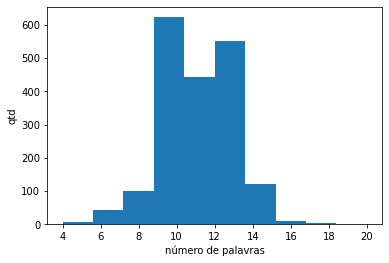

In [21]:
# histograma numero de palavras
turismo.title_n_words.hist()
plt.xlabel('número de palavras')
plt.ylabel('qtd')
plt.grid(b=None)
plt.show()

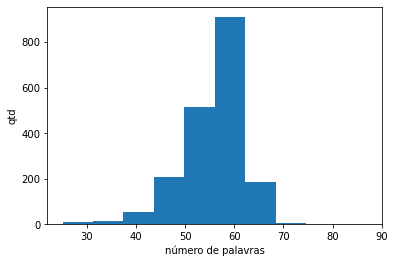

In [22]:
# histograma numero de letras
turismo.title_n_chars.hist()
plt.xlabel('número de palavras')
plt.ylabel('qtd')
plt.grid(b=None)
plt.show()

### limpeza os dados

In [23]:
nlpt_pt = spacy.load('pt_core_news_sm')

In [24]:
rev = turismo.iloc[0]['title']

In [25]:
rev

'Latam inaugura voo direto de 15 horas entre Chile e Austrália'

In [26]:
rev = limpa_texto(rev)

In [27]:
rev

'latam inaugura voo direto de 15 horas entre chile e austrália'

In [28]:
rev2 = turismo.iloc[5]['title']

In [29]:
rev2

"'Viagem ao Japão é aula de cultura e tradição', diz ator Jayme Matarazzo"

In [30]:
rev2 = limpa_texto(rev2)

In [31]:
rev2

'viagem ao japão é aula de cultura e tradição diz ator jayme matarazzo'

In [32]:
rev = nlpt_pt(rev)

In [33]:
rev

latam inaugura voo direto de 15 horas entre chile e austrália

In [34]:
def exibe_token(texto):
    col_names = ['ALPHA','PUNCT','LIKE NUM','POS']
    formatted_text = '{:>16}' * (len(col_names)+1)
    print('\n', formatted_text.format('INPUT WORD', *col_names), '\n','='*130)
    
    for token in texto:
        output = [token.text, token.is_alpha, token.is_punct, token.like_num, token.pos_]
        print(formatted_text.format(*output))

In [36]:
exibe_token(rev)


       INPUT WORD           ALPHA           PUNCT        LIKE NUM             POS 
           latam               1               0               0            VERB
        inaugura               1               0               0            VERB
             voo               1               0               0            NOUN
          direto               1               0               0             ADJ
              de               1               0               0             ADP
              15               0               0               1             NUM
           horas               1               0               0            NOUN
           entre               1               0               0             ADP
           chile               1               0               0            VERB
               e               1               0               0           CCONJ
       austrália               1               0               0            VERB


In [37]:
from spacy import displacy

In [39]:
displacy.render(rev, style='dep', jupyter=True)

In [38]:
rev2 = nlpt_pt(rev2)

In [100]:
exibe_token(rev2)


       INPUT WORD           ALPHA           PUNCT        LIKE NUM             POS 
          viagem               1               0               0            NOUN
              ao               1               0               0             ADP
           japão               1               0               0            NOUN
               é               1               0               0             AUX
            aula               1               0               0            NOUN
              de               1               0               0             ADP
         cultura               1               0               0            NOUN
               e               1               0               0           CCONJ
        tradição               1               0               0            NOUN
             diz               1               0               0            VERB
            ator               1               0               0            NOUN
           jayme         

In [40]:
turismo['title_clean'] = turismo['title'].apply(lambda x : limpa_texto(x))

In [41]:
turismo.head()

,title,text,date,category,subcategory,link,title_n_words,title_n_chars,title_clean
381,Latam inaugura voo direto de 15 horas entre Ch...,Animem-se os que pretendem cruzar o Pacífico e...,2017-06-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,11,51,latam inaugura voo direto de 15 horas entre ch...
414,Turismo de Las Vegas deve se recuperar em mese...,O massacre em Las Vegas afetará o turismo da c...,2017-06-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,11,54,turismo de las vegas deve se recuperar em mese...
522,Brasileiro cria app para economizar no passeio...,"Com cerca de 50 mil visitantes por dia, Veneza...",2017-05-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,11,58,brasileiro cria app para economizar no passeio...
602,AirBnB passa a fazer reserva de restaurantes,A plataforma de hospedagem Airbnb anunciou que...,2017-05-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,7,38,airbnb passa a fazer reserva de restaurantes
609,Museus lembram quatro décadas de opressão sovi...,Nos países que viveram sob a órbita da União S...,2017-05-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,10,62,museus lembram quatro décadas de opressão sovi...


In [42]:
turismo['title_clean_no_stop'] = turismo['title_clean'].apply(lambda x : remove_stop(x))

In [43]:
turismo.iloc[0]['title_clean']

'latam inaugura voo direto de 15 horas entre chile e austrália'

In [44]:
turismo.iloc[0]['title_clean_no_stop']

'latam inaugura voo direto 15 horas chile austrália'

### Lematização

In [45]:
turismo['title_lemmas'] = turismo['title_clean_no_stop'].apply(lambda x : limpa_texto2(x))

In [46]:
turismo.iloc[0]['title_lemmas']

'latir inaugurar voar direto 15 horar chile austrália'

In [47]:
turismo.iloc[5]['title_lemmas']

'viagem japão aula cultura tradição ator jayme matarazzo'

### N-grams

In [48]:
titulos = " ".join(turismo['title_lemmas'])

In [49]:
token = word_tokenize(titulos)

In [50]:
bigrams = ngrams(token,2)

In [51]:
Counter(bigrams).most_common(10)

[(('fotógrafo', 'registrar'), 39),
 (('atrair', 'turista'), 25),
 (('fotógrafo', 'clicar'), 23),
 (('álbum', 'viagem'), 22),
 (('companhia', 'aéreo'), 20),
 (('o', 'vegas'), 10),
 (('levar', 'turista'), 10),
 (('estação', 'esqui'), 10),
 (('o', 'angeles'), 10),
 (('opção', 'pacote'), 9)]

In [52]:
trigrams = ngrams(token,3)

In [53]:
Counter(trigrams).most_common(10)

[(('fotógrafo', 'registrar', 'paisagem'), 5),
 (('mundo', 'fotógrafo', 'registrar'), 5),
 (('gamar', 'of', 'thrones'), 5),
 (('world', 'trade', 'center'), 5),
 (('temer', 'ensaiar', 'fotográfico'), 4),
 (('parque', 'harry', 'potter'), 4),
 (('inaugurar', 'museu', 'dedicar'), 4),
 (('fotógrafo', 'registrar', 'cena'), 4),
 (('virar', 'atração', 'turístico'), 3),
 (('ter', 'montanha', 'russo'), 3)]

In [54]:
vectorizer = CountVectorizer(min_df=10, max_df= 0.9, stop_words=STOP_WORDS, lowercase=True)

In [55]:
data_vectorizer = vectorizer.fit_transform(turismo['title_lemmas'])

In [56]:
lda = LatentDirichletAllocation(n_components=2, max_iter=30, learning_method='online', verbose=True)

In [57]:
data_lda = lda.fit_transform(data_vectorizer)

iteration: 1 of max_iter: 30
iteration: 2 of max_iter: 30
iteration: 3 of max_iter: 30
iteration: 4 of max_iter: 30
iteration: 5 of max_iter: 30
iteration: 6 of max_iter: 30
iteration: 7 of max_iter: 30
iteration: 8 of max_iter: 30
iteration: 9 of max_iter: 30
iteration: 10 of max_iter: 30
iteration: 11 of max_iter: 30
iteration: 12 of max_iter: 30
iteration: 13 of max_iter: 30
iteration: 14 of max_iter: 30
iteration: 15 of max_iter: 30
iteration: 16 of max_iter: 30
iteration: 17 of max_iter: 30
iteration: 18 of max_iter: 30
iteration: 19 of max_iter: 30
iteration: 20 of max_iter: 30
iteration: 21 of max_iter: 30
iteration: 22 of max_iter: 30
iteration: 23 of max_iter: 30
iteration: 24 of max_iter: 30
iteration: 25 of max_iter: 30
iteration: 26 of max_iter: 30
iteration: 27 of max_iter: 30
iteration: 28 of max_iter: 30
iteration: 29 of max_iter: 30
iteration: 30 of max_iter: 30


In [58]:
import pyLDAvis.sklearn

In [60]:
pyLDAvis.enable_notebook()

/Users/dgoalmeida/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [61]:
dash = pyLDAvis.sklearn.prepare(lda, data_vectorizer, vectorizer, mds='tsne')

/Users/dgoalmeida/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [62]:
dash

/Users/dgoalmeida/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=               x           y  topics  cluster       Freq
topic                                                   
1     -60.312317  141.369629       1        1  51.178294
0      60.312561 -141.369141       2        1  48.821706, topic_info=          Term        Freq       Total Category  logprob  loglift
214    turista  188.000000  188.000000  Default  30.0000  30.0000
213    turismo  113.000000  113.000000  Default  29.0000  29.0000
114      hotel  105.000000  105.000000  Default  28.0000  28.0000
103  fotógrafo  101.000000  101.000000  Default  27.0000  27.0000
33      brasil   78.000000   78.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
11        alto   25.249067   26.740112   Topic2  -4.6911   0.6596
228  visitante   25.957648   27.784529   Topic2  -4.6635   0.6490
221     viagem   61.239078  114.935379   Topic2  -3.8051   0.0874
138      mundo   40.363876   81.783489   Topic2  -4.2220   0.0109
58    conhecer   32.626601   76.731852   Topic2  -4.4348  -0.1382

[108 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
6         1  0.970012      abrir
6         2  0.032334      abrir
7         1  0.044729  aeroporto
7         2  0.984032  aeroporto
9         1  0.039269     airbnb
...     ...       ...        ...
234       2  0.983528        voo
236       1  0.042205       york
236       2  0.970708       york
238       1  0.037156       água
238       2  0.966059       água

[150 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])